# Pearl Hacks 2023
Charis Williams, Elizabeth Surrat and I participated in our first hackathon. We didn't quite finish in the 24 hour window, but we made models, created some visualizations in Tableau and re-learned how to do all the time series modeling functions we knew from R in python. We had a fabulous time from trying to decide on a project to standing in line for Boba. This notebook shows some of the work from that day. We are planning to clean everything up for a presentation in April. 

## Real Estate trends
Time Series Analysis was one of our favorite classes. We went through our class notes and examples and looked up how to perform all the same functions in Python. We used data from https://www.redfin.com/news/data-center/ that had been aggregated on a county level. Our goal was to predict condo purchase prices 6 months into the future for three different counties in North Carolina. I picked Durham county. 

### Plan
1. Data exploration 
2. Ascertain seasonality
3. Select appropriate methods for dealing with seasonality, trend, and stationarity
4. Try two different models on a 6 month validation set
5. Rebuild better of two models on training + validation data
6. Apply better model on 6 month test set
7. Report metrics
8. Prepare Tableau dashboard model results and overall results
9. Bonus round: see if the townhouse sales follow the same trend as condos
 

We used a lot of libraries and tools that were new to us as our time series coursework used R exclusively. 

In [1]:
import pandas as pd
import numpy as np
#--- time series 
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm                   # for auto arima
# from statsmodels.tsa.forecasting.stl import STLForecast
# --- basic stats and error
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
# --- plotting
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates



This data set was a gz file that was unpacked and loaded into Excel to convert to csv. We learned later we could probably have used python to open the gz file. This file was directly downloaded from the redfin website. Kaggle also mentions this data as a good data source. (https://www.kaggle.com/datasets/vincentvaseghi/us-cities-housing-market-data)

In [2]:
df = pd.read_csv("data/county_market_tracker.csv")
df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['period_begin', 'period_end', 'period_duration', 'region_type',
       'region_type_id', 'table_id', 'is_seasonally_adjusted', 'region',
       'city', 'state', 'state_code', 'property_type', 'property_type_id',
       'median_sale_price', 'median_sale_price_mom', 'median_sale_price_yoy',
       'median_list_price', 'median_list_price_mom', 'median_list_price_yoy',
       'median_ppsf', 'median_ppsf_mom', 'median_ppsf_yoy', 'median_list_ppsf',
       'median_list_ppsf_mom', 'median_list_ppsf_yoy', 'homes_sold',
       'homes_sold_mom', 'homes_sold_yoy', 'pending_sales',
       'pending_sales_mom', 'pending_sales_yoy', 'new_listings',
       'new_listings_mom', 'new_listings_yoy', 'inventory', 'inventory_mom',
       'inventory_yoy', 'months_of_supply', 'months_of_supply_mom',
       'months_of_supply_yoy', 'median_dom', 'median_dom_mom',
       'median_dom_yoy', 'avg_sale_to_list', 'avg_sale_to_list_mom',
       'avg_sale_to_list_yoy', 'sold

In [3]:
# split out NC and Durham County condos
# select Durham county in NC
durham_nc = df[((df['state'].str.contains('North Ca')) &( df['region'].str.contains('Durham')))]
# create a date column in date format
# We decided to use beginning of the month
dates = pd.to_datetime(durham_nc['period_begin'])
durham_nc.insert(0, "date", dates)

In [4]:
# sort by date, find beginning and ending
print( durham_nc.sort_values('date').date.head(1), durham_nc.sort_values('date').date.tail(1))
# find number of unique dates
print(durham_nc.period_begin.nunique())


515130   2012-01-01
Name: date, dtype: datetime64[ns] 607004   2022-12-01
Name: date, dtype: datetime64[ns]
132


In [5]:
# find the property types
durham_nc.property_type.unique()

array(['Multi-Family (2-4 Unit)', 'All Residential', 'Condo/Co-op',
       'Townhouse', 'Single Family Residential'], dtype=object)

In [6]:
# select condos and the information needed for time series - which is only the price!
durham_condos = durham_nc[durham_nc['property_type'] == 'Condo/Co-op' ][['date', 'median_sale_price']]
# get townhouses while you are here
durham_townhome = durham_nc[durham_nc['property_type'] == 'Townhouse' ][['date', 'median_sale_price']]


In [7]:
# This is a way to load up and start here. 
# durham_condos.to_csv("durham_condos.csv", index=False)
# durham_townhome.to_csv("durham_townhome.csv", index=False)
durham_condos = pd.read_csv("durham_condos.csv")
durham_townhome = pd.read_csv("durham_townhome.csv")

In [8]:
durham_condos.info() # check out how many entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               132 non-null    object 
 1   median_sale_price  132 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


In [9]:
start_date = durham_condos.sort_values('date').date.iloc[0]
end_date = durham_condos.sort_values('date').date.iloc[-1]


In [10]:
durham_condos=durham_condos.sort_values('date') 
durham_condos.head()

,date,median_sale_price
13,2012-01-01,165000.0
29,2012-02-01,105000.0
100,2012-03-01,153450.0
34,2012-04-01,139900.0
96,2012-05-01,137450.0


In [11]:
# time series requires no missing dates. find out if missing date.
# https://www.geeksforgeeks.org/check-missing-dates-in-pandas/
# create a range of dates - then compare to the actual range in the data
my_range = pd.date_range(
  start=start_date, end=end_date, freq='MS') # month start
print(my_range.difference(durham_condos.date))
# there are no missing dates


DatetimeIndex([], dtype='datetime64[ns]', freq=None)


<AxesSubplot:xlabel='date', ylabel='median_sale_price'>

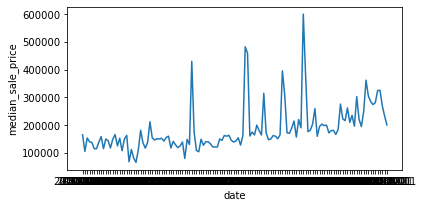

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))
 # Major ticks every half year, minor ticks every month,
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sns.lineplot(data = durham_condos, x='date', y='median_sale_price')
# this looks terrible - but I'll have to fix it later. 


In [13]:
# what months are the ones with the big spikes?
durham_condos[durham_condos.median_sale_price > 300000]

,date,median_sale_price
16,2015-12-01,430000.0
36,2017-11-01,482500.0
117,2017-12-01,459336.5
48,2018-07-01,314728.0
119,2019-03-01,395841.5
39,2019-04-01,308500.0
114,2019-12-01,600390.0
23,2020-01-01,378208.5
35,2021-11-01,302900.0
41,2022-03-01,362000.0


In [14]:
durham_condos = durham_condos.set_index('date') # set the index to date for time series


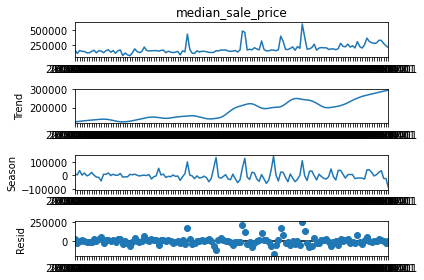

In [15]:
# do decomposition
stl = STL(durham_condos.median_sale_price, seasonal=7, period=12)
res = stl.fit()
fig = res.plot()

In [16]:
# use a 6 month validation set and a 6 month test set as we want to forecast 6 months into future. 
valid = durham_condos.tail(12)
valid = valid[ :-6]
test = durham_condos.tail(6)
train = durham_condos[:-12]

It is not clear there is a yearly (every 12 month) seasonality here. There is definitely a trend. 
Check to see if stationary before differencing on seasonal level and after. 

In [17]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

def kpss_test(timeseries, option='c'):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=option, nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [18]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
# regression options {“c”,”ct”,”ctt”,”n”} c is for constant only. ct is for constant with trend. 
def adf_test(timeseries, option='c'):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC", regression=option)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [19]:
# take seasonal differences and add to training data
# add as last column
train.insert( train.shape[1], "diff_data", train.median_sale_price.diff(12))


Results of Dickey-Fuller Test:
Test Statistic                -6.525395e+00
p-value                        1.622729e-07
#Lags Used                     1.100000e+01
Number of Observations Used    9.600000e+01
Critical Value (1%)           -4.056309e+00
Critical Value (5%)           -3.457255e+00
Critical Value (10%)          -3.154435e+00
dtype: float64


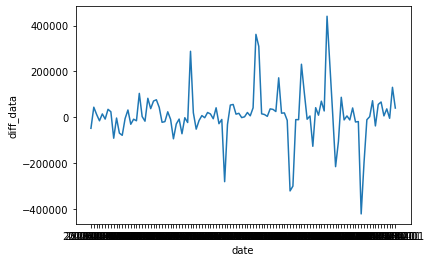

In [20]:
# do you have stationarity on differenced data?
sns.lineplot(data = train.tail(-12), x='date', y='diff_data')
# null hypothesis is The series has a unit root.(aka the series is NOT stationary.)
# this p value is small - you reject the null. you have some pattern left. 

adf_test(train.tail(-12).diff_data, 'ct')

Results of Dickey-Fuller Test:
Test Statistic                -7.667645e+00
p-value                        4.187460e-10
#Lags Used                     1.000000e+00
Number of Observations Used    1.180000e+02
Critical Value (1%)           -4.037614e+00
Critical Value (5%)           -3.448373e+00
Critical Value (10%)          -3.149257e+00
dtype: float64


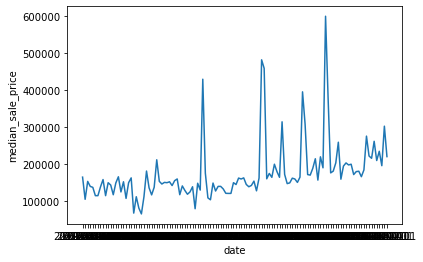

In [21]:
# do you have stationarity on undifferenced daata?
sns.lineplot(data = train, x='date', y='median_sale_price')
# null hypothesis is The series has a unit root.(aka the series is NOT stationary.)
# this p value is small - you reject the null. you have some pattern left. 

adf_test(train.median_sale_price, 'ct')

In [22]:
# take monthly differences on seasonal differences and add to training data
# add as last column
train.insert( train.shape[1], "mY_diff", train.diff_data.diff(1))
# also do differences of one lag on just the price. 
train.insert( train.shape[1], "month_diff", train.median_sale_price.diff(1))

In [23]:
adf_test(train.tail(-13).mY_diff, 'ct') # 13 rows of nan. 

Results of Dickey-Fuller Test:
Test Statistic                 -4.655360
p-value                         0.000832
#Lags Used                     13.000000
Number of Observations Used    93.000000
Critical Value (1%)            -4.059569
Critical Value (5%)            -3.458800
Critical Value (10%)           -3.155334
dtype: float64


In [24]:
adf_test(train.tail(-1).month_diff, 'ct') # one row of nan

Results of Dickey-Fuller Test:
Test Statistic                -7.710289e+00
p-value                        3.338338e-10
#Lags Used                     6.000000e+00
Number of Observations Used    1.120000e+02
Critical Value (1%)           -4.041963e+00
Critical Value (5%)           -3.450443e+00
Critical Value (10%)          -3.150465e+00
dtype: float64


In [25]:
# kpss test
# Null Hypothesis: The process is trend stationary. # fail to reject. 
kpss_test(train.tail(-12).diff_data, 'ct')

Results of KPSS Test:
Test Statistic           0.04112
p-value                  0.10000
Lags Used                3.00000
Critical Value (10%)     0.11900
Critical Value (5%)      0.14600
Critical Value (2.5%)    0.17600
Critical Value (1%)      0.21600
dtype: float64


C:\Users\zodia\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Dickey fuller tests indicate there is stationarity after seasonal differencing of 12 month season and then a single month lag random walk. The kpss test shows stationary after just the 12 month differencing. 

Let's look at the ACF and PACF. 

C:\Users\zodia\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


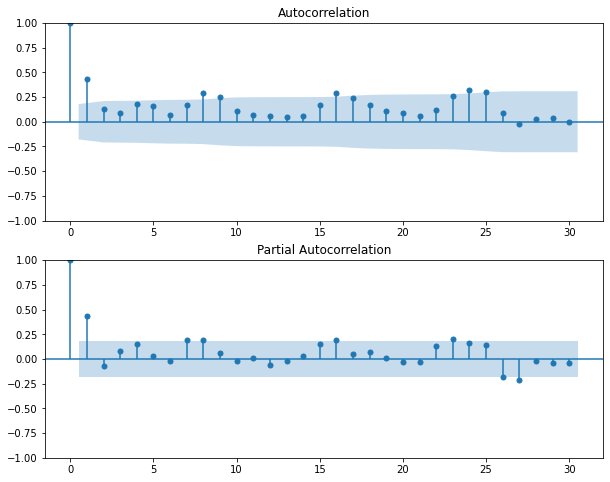

In [26]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train['median_sale_price'], lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train['median_sale_price'], lags=30, ax=ax2)



C:\Users\zodia\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


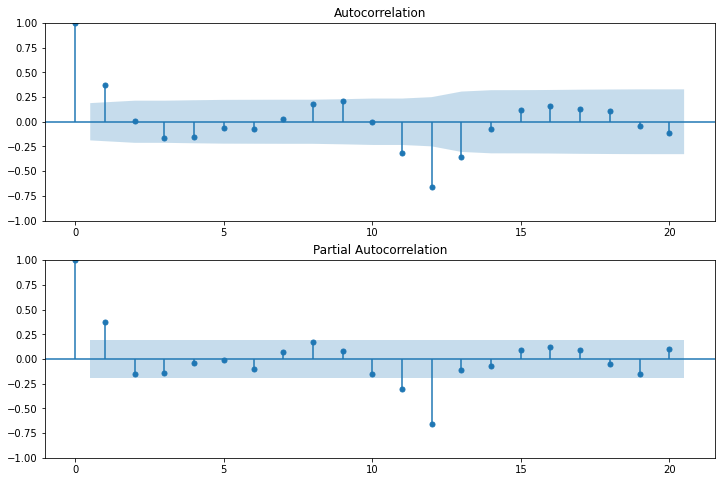

In [27]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train.tail(-12)['diff_data'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train.tail(-12)['diff_data'], lags=20, ax=ax2)



The ACF and PACF don't give a clear signal that differencing was the right thing to do! Or that there is a lot of correlation over a 12 month period. 
### auto arima 
Try auto arima with m=12 and m=1. Use the m=12 to seed sarimax function. 

In [28]:
model = pm.auto_arima(train['median_sale_price'], seasonal=True, m=12, stepwise=True) 
# trace=True to show the aic and terms as it searches
model
# used with sarimax

ARIMA(order=(4, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [29]:
model = pm.auto_arima(train['median_sale_price'], m=1, stepwise=True) 
# trace=True to show the aic and terms as it searches
model

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [30]:
forecast = model.predict(valid.shape[0]) # 
preds, conf_int = model.predict(n_periods=valid.shape[0], return_conf_int=True)


In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1497.699
Date:                Tue, 14 Feb 2023   AIC                           3003.398
Time:                        07:49:34   BIC                           3014.514
Sample:                             0   HQIC                          3007.912
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3283      0.110      2.976      0.003       0.112       0.544
ar.L2         -0.1626      0.163     -0.996      0.319      -0.482       0.157
ma.L1         -0.9233      0.072    -12.906      0.000      -1.063      -0.783
sigma2      5.804e+09   2.13e-11   2.72e+20      0.000     5.8e+09     5.8e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1181.36
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               6.75   Skew:                             3.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+36. Standard errors may be unstable.
"""

Try same coefficients in a Seasonal Arima. Different package. 

In [34]:
modsx = sm.tsa.statespace.SARIMAX(train['median_sale_price'], order=(4,1,1), seasonal_order=(1,0,1,12))
resultssx=modsx.fit()
forecastsx=resultssx.forecast(valid.shape[0]) 
# sarimax does not have get_forecast and uses predict for in sample

C:\Users\zodia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\zodia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [36]:
print(resultssx.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  median_sale_price   No. Observations:                  120
Model:             SARIMAX(4, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1496.131
Date:                            Tue, 14 Feb 2023   AIC                           3008.262
Time:                                    07:50:27   BIC                           3030.495
Sample:                                01-01-2012   HQIC                          3017.290
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2687      0.117      2.291      0.022       0.039       0.499
ar.L2         -0.1530      0.170   

null hypothesis for ljung-box is that you have no-autocorrelations. this is not a great ljung-box score on either the non-seasonal or the seasonal arima. Note the similar AIC. The non-seasonal has slightly lower. 

ShapiroResult(statistic=0.6917088031768799, pvalue=1.539027016722247e-14)

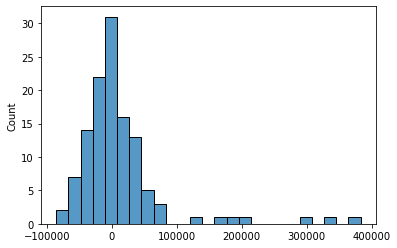

In [38]:
# the residuals are supposed to normal. This is from Seasonal.
sns.histplot(resultssx.resid) # this is from sarimax function
stats.shapiro(resultssx.resid) # null is that the residuals are normal. 

In [39]:
# create a dataframe for plotting 
v = valid.copy()
v.insert(v.shape[1],"f1", forecast)
v.insert(v.shape[1],"f2", forecastsx)

In [40]:
v

,median_sale_price,f1,f2
date,,,
2022-01-01,194950.0,207020.718747,216457.520202
2022-02-01,250000.0,215960.990294,217893.537653
2022-03-01,362000.0,221097.354558,220102.734742
2022-04-01,305250.0,221330.062602,208830.994442
2022-05-01,285000.0,220571.430658,220225.457097
2022-06-01,274000.0,220284.559574,214679.420331


<AxesSubplot:xlabel='date'>

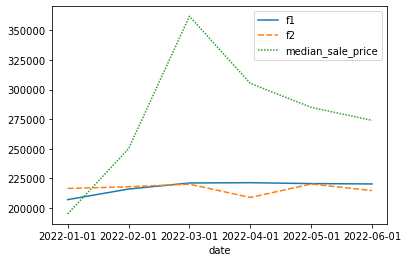

In [41]:
sns.lineplot(data=v[['f1', 'f2', 'median_sale_price']])

In [42]:
 #sklearn.metrics.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')[source]¶
print("mae = ", mean_absolute_error(valid['median_sale_price'], v.f1), 
      mean_absolute_error(valid['median_sale_price'], v.f2))
print("mape = ",mean_absolute_percentage_error(valid['median_sale_price'], v.f1), 
      mean_absolute_percentage_error(valid['median_sale_price'], v.f2))

mae =  64846.05351020696 69337.56265613729
mape =  0.2140559604581366 0.2317295084111843


Well! this is a pretty terrible MAPE. The non-seasonal model barely beats out the seasonal model. 

In [45]:
# look at the model as compared to the training -SARIMA
fitted=resultssx.predict(0,120)
t = train.copy()
t.insert(train.shape[1], "sarimaFit", fitted)
# not sure how to get the in-time fits for the autoarima model

<AxesSubplot:xlabel='date'>

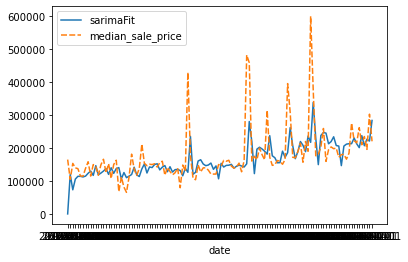

In [46]:
sns.lineplot(data=t[['sarimaFit', 'median_sale_price']])

In [47]:
# combine valid and train and fit the autoarima and sarimax and make predictions
comb = train.copy()
comb = pd.concat([comb, valid], axis=0)


In [48]:
# use the autoarima model to fit the combined data
# predict out for test
fcastTest = model.fit(comb.median_sale_price).predict(6)

In [49]:
print("mae = ", mean_absolute_error(test['median_sale_price'], fcastTest))
print("mape = ",mean_absolute_percentage_error(test['median_sale_price'], fcastTest))

mae =  46549.75143761922
mape =  0.16552130576255944


This model does better on the test than it did on the validation. 

In [50]:
test.insert(test.shape[1], "predict", fcastTest)


<AxesSubplot:xlabel='date'>

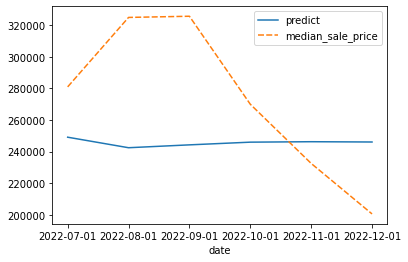

In [51]:
sns.lineplot(data=test[['predict','median_sale_price']])

Can't say that the model does a good job of capturing what is going on in the market here!

In [54]:
print(comb.median_sale_price.tail(12).mean())
print(test.predict.mean())

258138.54166666666
245681.77548029195


and the model may be worse than the average of the median sale price over the last 12 months! would need to calculate mape.

## next steps
Need to detrend the data and try again. ARIMA does differencing - but not trend. Although it looks like it followed pretty well in training set. 